In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc,os,sys

sns.set_style('darkgrid')
#sns.set_palette('bone')
pd.options.display.float_format = '{:,.3f}'.format

print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


# Load data

In [2]:
%%time
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print(train.shape, test.shape)

(200000, 202) (200000, 201)
CPU times: user 13.6 s, sys: 700 ms, total: 14.3 s
Wall time: 14.3 s


In [3]:
for c in train.columns:
    if c not in test.columns: print(c)

target


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


# Data analysis

In [5]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])

null count: Series([], dtype: int64)


In [6]:
#train.describe(include=np.number).drop('count').T

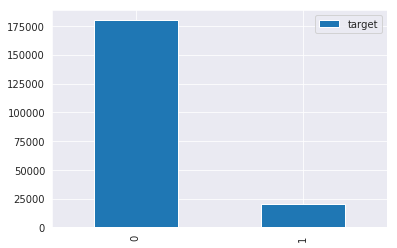

In [7]:
train['target'].value_counts().to_frame().plot.bar()

# Feature engineering

In [8]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

30

In [9]:
all_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0.000,8.925,-6.786,11.908,5.093,11.461,-9.283,5.119,18.627,-4.920,5.747,2.925,3.182,14.014,0.575,8.799,14.569,5.749,-7.239,4.284,30.713,10.535,16.219,2.579,2.472,14.383,13.432,-5.149,-0.407,4.931,5.997,-0.308,12.904,-3.877,16.891,11.192,10.579,0.676,7.887,...,15.458,5.313,3.616,5.038,6.676,12.664,2.700,-0.698,9.598,5.488,-4.764,-8.425,20.877,3.153,18.562,7.742,-10.124,13.724,-3.519,1.720,-8.405,9.016,3.066,14.369,25.840,5.876,11.841,-19.716,17.574,0.586,4.435,3.964,3.136,1.691,18.523,-2.398,7.878,8.563,12.780,-1.091
1,train_1,0.000,11.501,-4.147,13.859,5.389,12.362,7.043,5.621,16.534,3.147,8.085,-0.403,8.059,14.024,8.414,5.434,13.700,13.828,-15.585,7.800,28.571,3.429,2.741,8.552,3.372,6.978,13.891,-11.768,-2.559,5.046,0.548,-9.299,7.875,1.286,19.371,11.370,0.740,2.800,5.843,...,29.485,5.868,3.821,15.835,-5.012,15.134,3.200,9.319,3.882,5.800,5.538,5.099,22.033,5.513,30.265,10.497,-7.235,16.572,-7.348,11.075,-5.594,9.488,-14.910,9.425,22.544,-4.862,7.654,-15.932,13.318,-0.357,7.642,7.721,2.584,10.952,15.431,2.034,8.127,8.789,18.356,1.952
2,train_2,0.000,8.609,-2.746,12.081,7.893,10.582,-9.084,6.943,14.616,-4.919,5.952,-0.325,-11.265,14.193,7.312,7.524,14.647,7.678,-1.740,4.701,20.477,17.756,18.138,1.214,3.514,5.678,13.218,-7.994,-2.903,5.846,6.144,-11.102,12.486,-2.287,19.042,11.045,4.109,4.697,6.935,...,13.207,5.844,4.709,5.714,-1.041,20.509,3.279,-5.595,7.318,5.769,-7.093,-3.912,7.257,-5.823,25.682,10.920,-0.310,8.844,-9.701,2.401,-4.293,9.391,-13.265,3.155,23.087,-5.300,5.375,-6.266,10.193,-0.842,2.906,9.790,1.670,1.686,21.604,3.142,-6.521,8.268,14.722,0.397
3,train_3,0.000,11.060,-2.152,8.952,7.196,12.585,-1.836,5.843,14.925,-5.861,8.245,2.306,2.810,13.846,11.970,6.457,14.837,10.743,-0.430,15.943,13.726,20.301,12.558,6.820,2.723,12.135,13.737,0.814,-0.906,5.907,2.841,-15.240,10.441,-2.573,6.180,10.609,-5.916,8.172,2.852,...,31.883,5.968,7.208,3.890,-11.088,17.250,2.588,-2.702,0.564,5.343,-7.154,-6.192,18.237,11.713,14.748,8.101,11.877,13.955,-10.470,5.696,-3.755,8.412,1.899,7.260,-0.464,-0.050,7.934,-12.828,12.412,1.849,4.467,4.743,0.718,1.421,23.035,-1.271,-2.928,10.292,17.970,-9.000
4,train_4,0.000,9.837,-1.483,12.875,6.638,12.277,2.449,5.941,19.251,6.265,7.678,-9.446,-12.142,13.848,7.889,7.789,15.055,8.487,-3.068,6.526,11.315,21.425,18.961,10.110,2.714,14.208,13.543,3.174,-3.342,5.902,7.935,-3.158,9.467,-0.008,19.324,12.406,0.633,2.792,5.818,...,33.511,5.695,5.466,18.220,6.577,21.261,3.230,-1.776,3.128,5.552,1.449,-2.663,19.806,2.370,18.468,16.331,-3.346,13.526,1.719,5.174,-7.694,9.768,4.891,12.220,11.850,-7.893,6.421,5.927,16.020,-0.283,-1.490,9.521,-0.151,9.194,13.288,-1.512,3.927,9.503,17.997,-8.810


In [10]:
numcols = all_data.drop('target',axis=1).select_dtypes(include='number').columns.values

- drop constant columns

In [11]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: []


- drop high correlation columns

In [12]:
corr_matrix = all_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
del upper

drop_column = all_data.columns[to_drop]
print('drop columns:', drop_column)
#all_data.drop(drop_column, axis=1, inplace=True)

drop columns: Index([], dtype='object')


- factorize

In [13]:
cols = [col for col in all_data.columns if col not in ['ID_code']]
for i, t in all_data.loc[:, cols].dtypes.iteritems():
    if t == object:
        print(i)
        all_data[i] = pd.factorize(all_data[i])[0]

- scaling

In [14]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MaxAbsScaler()
all_data.loc[:,numcols] = scaler.fit_transform(all_data[numcols])

In [15]:
_='''noneffective
feats = ["var_{}".format(i) for i in range(200)]
for f in feats:
    all_data[f] = pd.cut(all_data[f], 100, labels=range(100))
'''

In [16]:
all_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0.000,-0.574,-1.276,0.454,-0.830,0.237,-0.537,-0.339,0.611,-1.560,-1.477,0.462,1.079,-0.051,-1.718,0.561,-0.010,-1.403,-0.229,-1.398,2.285,-0.469,-0.125,-0.605,-1.039,1.009,-0.822,-0.190,0.477,-0.766,0.362,0.926,1.161,-1.297,0.491,-0.448,1.299,-0.488,0.894,...,-0.804,-1.473,-1.227,-1.135,1.748,-1.322,-0.710,0.444,1.506,-0.400,-1.075,-1.414,0.124,0.640,-0.235,-1.349,-0.974,0.704,-0.296,-0.309,-1.082,-0.778,0.266,1.253,1.406,2.085,0.896,-0.813,0.559,-0.169,0.269,-1.152,0.818,-0.410,0.168,-1.581,1.024,-0.376,-1.027,0.211
1,train_1,0.000,0.274,-0.623,1.193,-0.685,0.793,1.538,0.241,-0.001,0.860,0.419,-0.143,1.897,0.003,-0.026,-0.933,-2.121,1.764,-1.469,-0.950,2.017,-1.678,-1.769,1.493,0.667,-0.953,0.784,-1.306,-0.935,-0.619,-1.723,-0.202,-1.169,0.697,1.064,-0.119,-0.602,0.192,-0.013,...,0.486,1.074,-1.083,0.915,-0.393,-0.831,0.641,1.727,-0.340,0.449,1.255,1.100,0.258,1.035,1.405,-0.395,-0.590,1.788,-0.742,3.030,-0.546,-0.434,-1.740,0.147,1.052,-0.188,-0.413,-0.486,-0.522,-1.134,0.972,0.090,0.444,1.909,-0.817,1.519,1.070,-0.132,0.826,0.503
2,train_2,0.000,-0.678,-0.277,0.519,0.537,-0.306,-0.512,1.768,-0.562,-1.560,-1.310,-0.129,-1.342,0.892,-0.264,-0.005,0.179,-0.646,0.589,-1.345,1.005,0.759,0.109,-1.085,0.937,-1.298,-1.575,-0.670,-1.161,0.401,0.418,-0.429,0.967,-0.683,0.988,-0.720,0.049,0.800,0.472,...,-1.011,0.963,-0.459,-1.007,0.334,0.237,0.853,-0.182,0.770,0.365,-1.601,-0.575,-1.446,-0.862,0.763,-0.249,0.329,-1.153,-1.017,-0.066,-0.298,-0.505,-1.556,-1.256,1.111,-0.281,-1.126,0.350,-1.315,-1.631,-0.067,0.774,-0.173,-0.411,1.150,2.294,-1.618,-0.698,-0.381,0.354
3,train_3,0.000,0.129,-0.130,-0.667,0.197,0.931,0.410,0.498,-0.471,-1.843,0.549,0.349,1.017,-0.931,0.741,-0.479,0.641,0.555,0.783,0.088,0.160,1.192,-0.572,0.885,-0.563,0.413,0.243,0.814,0.149,0.478,-0.846,-0.948,0.019,-0.794,-1.986,-1.525,-1.888,1.914,-1.340,...,0.706,1.533,1.298,-1.353,-1.507,-0.411,-1.013,0.188,-1.411,-0.794,-1.615,-0.999,-0.180,2.072,-0.769,-1.224,1.946,0.792,-1.107,1.110,-0.195,-1.219,0.135,-0.338,-1.417,0.830,-0.325,-0.217,-0.752,1.125,0.275,-0.894,-0.817,-0.477,1.606,-0.792,-0.959,1.500,0.698,-0.548
4,train_4,0.000,-0.274,0.035,0.820,-0.076,0.741,0.954,0.610,0.793,1.796,0.089,-1.785,-1.489,-0.922,-0.139,0.113,1.171,-0.329,0.391,-1.112,-0.142,1.383,0.209,2.041,-0.579,0.962,-0.434,1.212,-1.449,0.471,1.104,0.568,-0.432,0.197,1.054,1.794,-0.623,0.190,-0.024,...,0.856,0.280,0.073,1.369,1.730,0.386,0.722,0.306,-0.583,-0.226,0.331,-0.343,0.001,0.509,-0.248,1.625,-0.074,0.629,0.315,0.924,-0.946,-0.230,0.469,0.772,-0.095,-0.830,-0.798,1.404,0.165,-1.059,-1.032,0.685,-1.405,1.469,-1.500,-0.961,0.299,0.643,0.707,-0.530


## Preparation

In [17]:
X_train = all_data[all_data['target'].notnull()].reset_index(drop=True)
X_test = all_data[all_data['target'].isnull()].drop(['target'], axis=1).reset_index(drop=True)
del all_data
gc.collect()

# drop ID_code
X_train.drop(['ID_code'], axis=1, inplace=True)
X_test_ID = X_test.pop('ID_code')

Y_train = X_train.pop('target')

print(X_train.shape, X_test.shape)

(200000, 200) (200000, 200)


In [18]:
_='''
def get_redundant_pairs(df):
    # Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train))
'''

In [19]:
_='''noneffective
from imblearn.over_sampling import SMOTE,ADASYN
#from imblearn.combine import SMOTETomek

sm = SMOTE(random_state=42)
#sm = SMOTE(kind='svm',random_state=42)
#sm = SMOTE(kind='borderline1',random_state=42)
#sm = ADASYN(random_state=42)
#sm = SMOTETomek(random_state=42)
X_train, Y_train = sm.fit_sample(X_train, Y_train)
X_train = pd.DataFrame(X_train, columns=X_test.columns)
print(X_train.shape)
'''

In [20]:
#X_train['_negval'] = X_train.apply(lambda x: (x < 0).astype(int).sum(), axis=1)
#X_test['_negval'] = X_train.apply(lambda x: (x < 0).astype(int).sum(), axis=1)

## KMeans

1    108310
0     91690
dtype: int64
1    107209
0     92791
dtype: int64


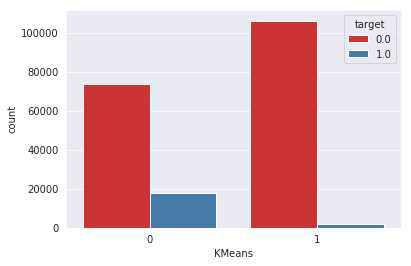

In [21]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, init='k-means++', max_iter=3000, random_state=42)
X_train_km = km.fit_predict(X_train)
X_test_km = km.predict(X_test)

print(pd.Series(X_train_km).value_counts())
print(pd.Series(X_test_km).value_counts())

km_data = pd.DataFrame({'KMeans':X_train_km, 'target':Y_train})
sns.countplot(x='KMeans', hue='target', palette='Set1', data=km_data)

## PCA, LDA, NB

- PCA is noneffective

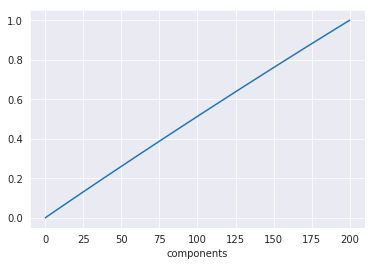

In [22]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold
from sklearn import metrics

pca = PCA()
pca.fit(X_train)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0,ev_ratio.cumsum()])

plt.xlabel('components')
plt.plot(ev_ratio)
plt.show()

In [23]:
_='''
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break
            
    return n_components

lda = LDA(n_components=None)
lda.fit(X_train, Y_train)
print(select_n_components(lda.explained_variance_ratio_, 0.95))
'''

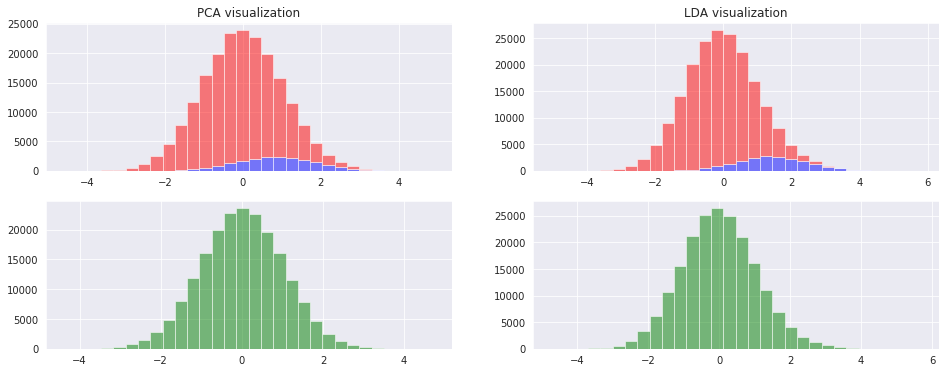

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))
ax = ax.ravel()

pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
pca_1 = X_train_pca[Y_train > 0].reshape(-1)
pca_0 = X_train_pca[Y_train == 0].reshape(-1)
ax[0].hist([pca_1, pca_0], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[0].set_title('PCA visualization')

lda = LDA(n_components=1)
lda.fit(X_train, Y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
lda_1 = X_train_lda[Y_train > 0].reshape(-1)
lda_0 = X_train_lda[Y_train == 0].reshape(-1)
ax[1].hist([lda_1, lda_0], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[1].set_title('LDA visualization')

ax[2].hist(X_test_pca, color='g', bins=30, alpha=0.5, histtype='barstacked')
ax[3].hist(X_test_lda, color='g', bins=30, alpha=0.5, histtype='barstacked')

plt.show()

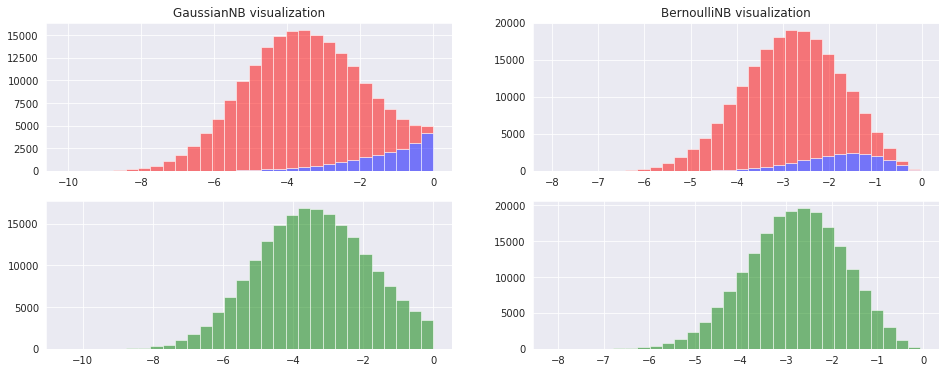

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))
ax = ax.ravel()

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
X_train_gnb = gnb.predict_log_proba(X_train)[:,1]
X_test_gnb = gnb.predict_log_proba(X_test)[:,1]
gnb_1 = X_train_gnb[Y_train > 0].reshape(-1)
gnb_0 = X_train_gnb[Y_train == 0].reshape(-1)
ax[0].hist([gnb_1, gnb_0], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[0].set_title('GaussianNB visualization')

bnb = BernoulliNB()
bnb.fit(X_train, Y_train)
X_train_bnb = bnb.predict_log_proba(X_train)[:,1]
X_test_bnb = bnb.predict_log_proba(X_test)[:,1]
bnb_1 = X_train_bnb[Y_train > 0].reshape(-1)
bnb_0 = X_train_bnb[Y_train == 0].reshape(-1)
ax[1].hist([bnb_1, bnb_0], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[1].set_title('BernoulliNB visualization')

ax[2].hist(X_test_gnb, color='g', bins=30, alpha=0.5, histtype='barstacked')
ax[3].hist(X_test_bnb, color='g', bins=30, alpha=0.5, histtype='barstacked')

plt.show()

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


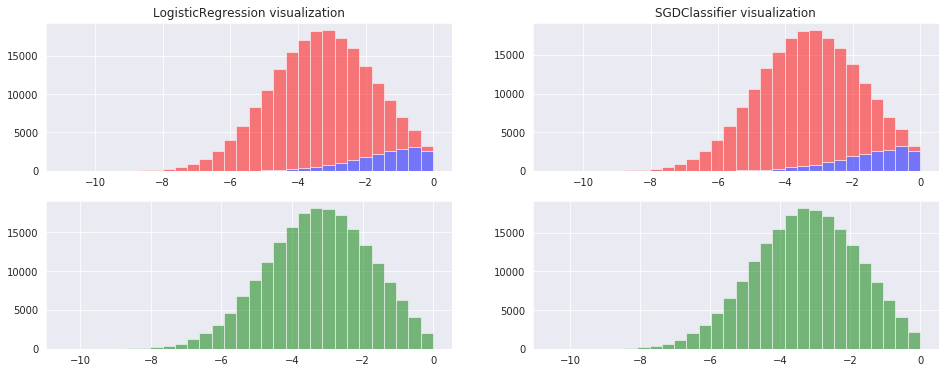

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))
ax = ax.ravel()

lgr = LogisticRegression()
lgr.fit(X_train, Y_train)
X_train_lgr = lgr.predict_log_proba(X_train)[:,1]
X_test_lgr = lgr.predict_log_proba(X_test)[:,1]
lgr_1 = X_train_lgr[Y_train > 0].reshape(-1)
lgr_0 = X_train_lgr[Y_train == 0].reshape(-1)
ax[0].hist([lgr_1, lgr_0], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[0].set_title('LogisticRegression visualization')
ax[2].hist(X_test_lgr, color='g', bins=30, alpha=0.5, histtype='barstacked')

sgd = SGDClassifier(max_iter=10000, loss='log', tol=1e-5)
sgd.fit(X_train, Y_train)
X_train_sgd = sgd.predict_log_proba(X_train)[:,1]
X_test_sgd = sgd.predict_log_proba(X_test)[:,1]
sgd_1 = X_train_sgd[Y_train > 0].reshape(-1)
sgd_0 = X_train_sgd[Y_train == 0].reshape(-1)
ax[1].hist([sgd_1, sgd_0], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[1].set_title('SGDClassifier visualization')
ax[3].hist(X_test_sgd, color='g', bins=30, alpha=0.5, histtype='barstacked')
plt.show()

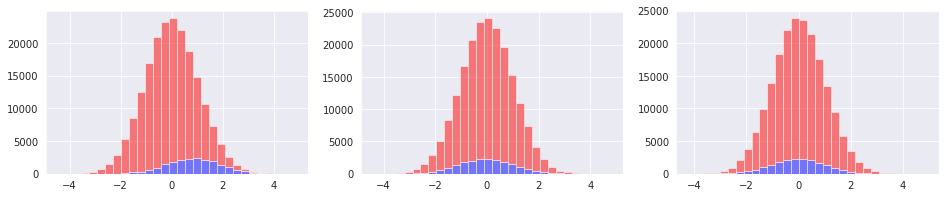

In [27]:
_='''
'''
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

color = list(map(lambda x: 'r' if x == 1 else 'b', Y_train))
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
ax[0].hist([X_train_pca[:,0][Y_train > 0], X_train_pca[:,0][Y_train == 0]], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[1].hist([X_train_pca[:,1][Y_train > 0], X_train_pca[:,1][Y_train == 0]], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
ax[2].hist([X_train_pca[:,2][Y_train > 0], X_train_pca[:,2][Y_train == 0]], color=['b','r'], bins=30, alpha=0.5, histtype='barstacked')
plt.show()

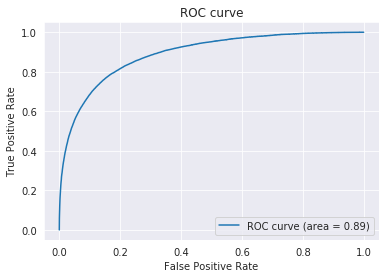

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(Y_train, X_train_gnb)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(PCA(n_components=1), X_train, Y_train, cv=skf)
print("PCA, Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    
scores = cross_val_score(LDA(n_components=1), X_train, Y_train, cv=skf) # max components is (classes - 1)
print("LDA, Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    
scores = cross_val_score(GaussianNB(), X_train, Y_train, cv=skf)
print("GNB, Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(BernoulliNB(), X_train, Y_train, cv=skf)
print("BNB, Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

#scores = cross_val_score(LogisticRegression(), X_train, Y_train, cv=skf)
#print("LGR, Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(SGDClassifier(max_iter=3000, loss='log', tol=1e-4), X_train, Y_train, cv=skf)
print("SGD, Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

PCA, Accuracy: -283.7806 (+/- 0.1178)
LDA, Accuracy: 0.9142 (+/- 0.0010)
GNB, Accuracy: 0.9213 (+/- 0.0010)
BNB, Accuracy: 0.9023 (+/- 0.0004)
SGD, Accuracy: 0.9132 (+/- 0.0010)


In [30]:
_='''noneffective
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
X_all_tsne = tsne.fit_transform(pd.concat([n_train,n_test]))
X_train_tsne = X_all_tsne[:n_train.shape[0]]
X_test_tsne = X_all_tsne[n_train.shape[0]:]
print(X_train_tsne.shape)

plt.figure(figsize=(6,6))
plt.scatter(X_train_tsne[:,0], X_train_tsne[:,1], c=color, alpha=0.3)
plt.title("t-SNE visualization")
plt.show()

n_train['tnse1'] = X_train_tsne[:,0]
n_test['tnse1'] = X_test_tsne[:,0]
n_train['tnse2'] = X_train_tsne[:,1]
n_test['tnse2'] = X_test_tsne[:,1]
'''

In [31]:
n_train = pd.DataFrame()
n_test = pd.DataFrame()

'''
for df in [train, test]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
'''
n_train['_var'] = X_train[numcols].var(axis=1)
n_test['_var'] = X_test[numcols].var(axis=1)
n_train['_sum'] = X_train[numcols].sum(axis=1)
n_test['_sum'] = X_test[numcols].sum(axis=1)

n_train['_km'] = X_train_km
n_test['_km'] = X_test_km
n_train['_lda'] = X_train_lda
n_test['_lda'] = X_test_lda
#n_train['pca'] = X_train_pca
#n_test['pca'] = X_test_pca
for n in range(0,X_train_pca.shape[1]):
    n_train['_pca'+str(n+1)] = X_train_pca[:,n]
    n_test['_pca'+str(n+1)] = X_test_pca[:,n]
n_train['_lgr'] = X_train_lgr
n_test['_lgr'] = X_test_lgr
n_train['_sgd'] = X_train_sgd
n_test['_sgd'] = X_test_sgd
n_train['_gnb'] = X_train_gnb
n_test['_gnb'] = X_test_gnb
n_train['_bnb'] = X_train_bnb
n_test['_bnb'] = X_test_bnb

In [32]:
_='''
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
n_train = poly.fit_transform(n_train)
n_test = poly.transform(n_test)

for c in n_train.columns:
    n_train[c+'_r'] = rankdata(n_train[c]).astype('float32')
    n_train[c+'_n'] = norm.cdf(n_train[c]).astype('float32')
    n_test[c+'_r'] = rankdata(n_test[c]).astype('float32')
    n_test[c+'_n'] = norm.cdf(n_test[c]).astype('float32')
'''

In [33]:
n_train = pd.DataFrame(n_train)
n_test = pd.DataFrame(n_test)

In [34]:
X_train = pd.concat([X_train, n_train], axis=1)
X_test = pd.concat([X_test, n_test], axis=1)

In [35]:
_='''noneffective
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

feat = SelectKBest(f_classif, k=50)
feat.fit(X_train, Y_train)

X_train = X_train.loc[:,feat.get_support()]
X_test = X_test.loc[:,feat.get_support()]
'''

In [36]:
print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:5])

        name       size
0    X_train  336800104
1     X_test  336800104
2    n_train   16800104
3     n_test   16800104
4  X_test_ID   13488994


# Predict

- LGBMClassifier

In [37]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

params={'learning_rate': 0.01,
        'objective':'binary',
        'metric':'auc',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'is_unbalance':'true',
        #'scale_pos_weight': 2,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.6
       }

folds = StratifiedKFold(n_splits=10)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    train_data = lgb.Dataset(trn_x, label=trn_y)
    valid_data = lgb.Dataset(val_x, label=val_y)    
    lgb_model = lgb.train(params, train_data, num_boost_round=100000,
                valid_sets=[train_data, valid_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof_preds[val_] = lgb_model.predict(X_train.iloc[valid_index], num_iteration=lgb_model.best_iteration)
    sub_preds += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_) / folds.n_splits
    '''
    model = lgb.LGBMClassifier(**params, n_estimators=10000)
    model.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=1000, verbose=1000)

    oof_preds[val_] = model.predict_proba(val_x, num_iteration=model.best_iteration_)[:,1]
    sub_preds += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1] / folds.n_splits
    '''

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.92791	valid_1's auc: 0.894313
[2000]	training's auc: 0.948358	valid_1's auc: 0.894426
[3000]	training's auc: 0.962904	valid_1's auc: 0.893721
[4000]	training's auc: 0.973773	valid_1's auc: 0.893192
Early stopping, best iteration is:
[1501]	training's auc: 0.939229	valid_1's auc: 0.894537


NameError: name 'valid_index' is not defined

In [38]:
# Plot feature importance
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 20:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

NameError: name 'model' is not defined

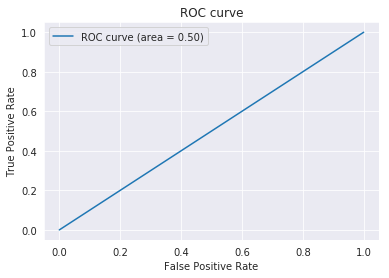

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

- CatBoostClassifier

In [40]:
_='''
from catboost import CatBoostClassifier

folds = StratifiedKFold(n_splits=5)
oof2_preds = np.zeros(X_train.shape[0])
sub2_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]
    
    model = CatBoostClassifier(iterations=10000, learning_rate=0.01, objective="Logloss", eval_metric='AUC')
    model.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], verbose=500) #early_stopping_rounds=100, 

    oof2_preds[val_] = model.predict_proba(val_x)[:,1]
    sub2_preds += model.predict_proba(X_test)[:,1] / folds.n_splits
'''

In [41]:
#preds = sub_preds * 0.7 + sub2_preds * 0.3
preds = sub_preds

# Submit

In [42]:
submission = pd.DataFrame({
    'ID_code': X_test_ID,
    'target': preds
})
submission.to_csv("submission.csv", index=False)

In [43]:
submission['target'].sum()

0.0